# minimal

In [548]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

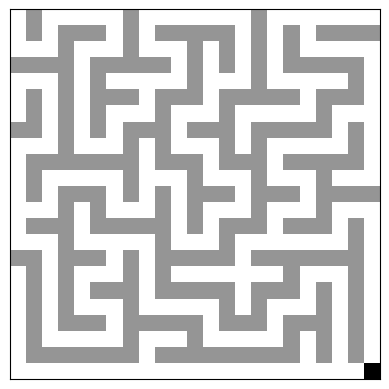

_@_____@_______@_______
_@_@@@_@_@@@@@_@_@_@@@@
___@___@___@_@_@_@_____
@@@@_@@@@@_@_@_@_@@@@@_
___@_@_____@___@_____@_
_@_@_@@@_@@@_@@@@@_@@@_
_@_@_@___@___@_____@___
@@_@_@_@@@_@@@_@@@@@_@_
___@___@_@___@_@_____@_
_@@@@@@@_@@@_@@@_@@@@@_
_@_____@___@___@___@___
_@_@@@_@_@_@@@_@@@_@@@@
___@_@___@_@___@___@___
_@@@_@@@@@_@_@@@_@@@_@_
___@_____@___@_______@_
@@_@@@_@_@@@@@_@@@@@@@_
_@_@___@_@_______@___@_
_@_@_@@@_@@@@@_@@@_@_@_
_@_@___@_____@_@___@_@_
_@_@@@_@@@@@_@@@_@@@_@_
_@_____@___@_____@_@_@_
_@@@@@@@_@@@@@@@@@_@_@_
______________________x


In [610]:
# maze generator
def make_maze(width):
    maze = torch.zeros((width, width))
    moves = list(MOVES.keys())

    def add_exit(maze):
        choices = (maze == 1).nonzero().tolist()
        furthest = max(choices, key=lambda x: x[0] + x[1])
        maze[furthest[0], furthest[1]] = -1

    def rec(x, y):
        while True:
            pairs = []
            for move in moves:
                dx, dy = move
                nx, ny = x + dx, y + dy
                nnx, nny = nx + dx, ny + dy
                if 0 <= nnx < width and 0 <= nny < width and maze[nnx, nny] == 0 and maze[nx, ny] == 0:
                    pairs.append((nx, ny, nnx, nny))
            random.shuffle(pairs)
            if not pairs: break
            nx, ny, nnx, nny = pairs[0]
            maze[nx, ny], maze[nnx, nny] = 1, 1
            rec(nnx, nny)

    maze[0, 0] = 1
    rec(0, 0)
    add_exit(maze)
    return maze

def ascii_maze(maze):
    lookup = {0: '@', 1: '_', -1: 'x'}
    print('\n'.join(''.join(lookup[i] for i in row) for row in maze.tolist()))

def plot_maze(maze):
    plt.imshow(-maze, 'Greys')
    plt.xticks([], [])
    plt.yticks([], [])
    plt.show()

# look at the maze
maze = make_maze(23)
plot_maze(maze)
ascii_maze(maze)

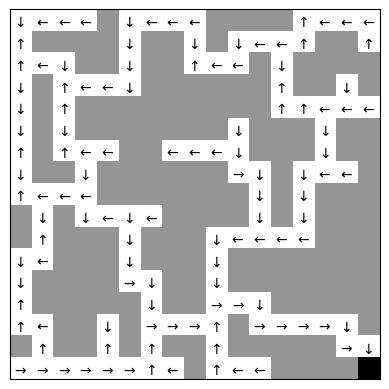

In [566]:
# helper functions
def plot_policy(model, maze):
    dirs = {
        0: '↑',
        1: '↓',
        2: '←',
        3: '→',
    }
    with torch.no_grad():
        fig, ax = plt.subplots()
        ax.imshow(-maze, 'Greys')
        for pos in (maze == 1).nonzero().tolist():
            q = model(to_input(maze, pos))
            action = int(torch.argmax(q).detach().cpu().item())
            dir = dirs[action]
            ax.text(pos[1] - 0.3, pos[0] + 0.3, dir) # center arrows in empty slots
        
        plt.xticks([], [])
        plt.yticks([], [])
        plt.show()

# plot_policy(model, default_maze)

In [668]:
# default_maze = torch.tensor([
#     [1, 0, 0, 0, 0],
#     [1, 1, 1, 1, 1],
#     [0, 1, 0, 1, 0],
#     [1, 1, 0, 0, 0],
#     [1, 1, 1, 1, -1],
# ])

# default_maze = torch.tensor([
#     [1, 1, 1, 1, 1],
#     [0, 0, 0, 1, 0],
#     [1, 1, 1, 1, 1],
#     [1, 0, 0, 0, 0],
#     [1, 1, 1, 1, -1],
# ])

default_maze = torch.tensor([
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1, 0, 0, 1],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, -1],
])

# default_maze = torch.tensor([
#     [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1],
#     [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1],
#     [1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0],
#     [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
#     [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
#     [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
#     [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
#     [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0],
#     [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
#     [0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
#     [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
#     [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
#     [1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
#     [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
#     [1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0],
#     [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
#     [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, -1],
# ])

# default_maze = torch.tensor([
#     [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1],
#     [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1],
#     [1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0],
#     [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
#     [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
#     [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
#     [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
#     [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0],
#     [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
#     [0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
#     [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0],
#     [1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
#     [1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
#     [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
#     [1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0],
#     [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
#     [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, -1],
# ])

MAZE_WIDTH = default_maze.shape[0]
INPUT_SIZE = MAZE_WIDTH * MAZE_WIDTH + 2 * MAZE_WIDTH
MOVES = {
    (-1, 0): torch.tensor(0).to(device), # up
    (1, 0):  torch.tensor(1).to(device), # down
    (0, -1): torch.tensor(2).to(device), # left
    (0, 1):  torch.tensor(3).to(device),  # right
 }

# policy
HIT_WALL_PENALTY = -1
MOVE_PENALTY = 0
WIN_REWARD = 10
 
# hyperparams
METHOD = 'exhaustive_search'
EXPLORATION = 0.9
GAMMA_DECAY = 0.95
HIDDEN_SIZE = INPUT_SIZE
EPOCH = 1000
BATCH_SIZE = 512
LEARNING_RATE = 1e-3

def get_maze():
    maze = default_maze
    # maze = make_maze(MAZE_WIDTH)
    rewards = torch.zeros_like(maze)
    rewards[maze == 0] = HIT_WALL_PENALTY
    rewards[maze == 1] = MOVE_PENALTY
    rewards[maze == -1] = WIN_REWARD
    return maze, rewards

def get_reward(rewards, pos):
    x, y = pos
    a, b = rewards.shape
    if 0 <= x < a and 0 <= y < b:
        return rewards[x, y]
    return HIT_WALL_PENALTY

def get_next_pos(maze, rewards, pos, move):
    is_terminal = True
    new_pos = pos # default to forbidden move.
    reward = HIT_WALL_PENALTY # default to hitting a wall.
    x, y = pos
    a, b = maze.shape
    i, j = move
    if 0 <= x + i < a and 0 <= y + j < b:
        new_pos = (x + i, y + j)
        reward = get_reward(rewards, new_pos)
        is_terminal = maze[new_pos] != 1
    return new_pos, reward, move, is_terminal

def get_batch_randomized():
    batch = []
    maze, rewards = get_maze()
    positions = random.choices((maze == 1).nonzero().tolist(), k=BATCH_SIZE)
    for pos in positions:
        new_pos, reward, move, is_terminal = get_next_pos(maze, rewards, pos, random.choice(list(MOVES.keys())))
        batch.append((pos, move, new_pos, reward, is_terminal))
    return maze, batch

def get_batch_exhaustive_search():
    batch = []
    maze, rewards = get_maze()
    for pos in (maze == 1).nonzero().tolist():
        for mm in list(MOVES.keys()):
            new_pos, reward, move, is_terminal = get_next_pos(maze, rewards, pos, mm)
            batch.append((pos, move, new_pos, reward, is_terminal))
    return maze, batch

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, len(MOVES)),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)        
        return logits

def to_input(maze, pos):
    return torch.cat((
        maze.view(-1),
        F.one_hot(torch.tensor(pos), num_classes=MAZE_WIDTH).view(-1),
    )).float().to(device)

def train(model):
    METHODS = {
        'exhaustive_search': get_batch_exhaustive_search,
        'random': get_batch_randomized,
    }
    get_batch = METHODS[METHOD]
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    losses = []
    for epoch in range(EPOCH):
        maze, batch = get_batch()

        # train vectorized
        xs, ms, ys, rs, terminal = [], [], [], [], []
        for pos, move, new_pos, reward, is_terminal in batch:
            xs.append(to_input(maze, pos))
            ms.append(F.one_hot(MOVES[move], num_classes=len(MOVES)))
            ys.append(to_input(maze, new_pos))
            rs.append(reward)
            terminal.append(0. if is_terminal else 1.) # no Q'(s', a') if terminal state

        XS = torch.stack(xs).to(device)
        MS = torch.stack(ms).to(device)
        YS = torch.stack(ys).to(device)
        RS = torch.tensor(rs).to(device).view(-1, 1)
        TERMINAL = torch.tensor(terminal).to(device).view(-1, 1)
        bellman_left = (model(XS) * MS).sum(dim=1, keepdim=True)
        qqs = model(YS).max(dim=1, keepdim=True).values
        bellman_right = RS + qqs * TERMINAL * GAMMA_DECAY
        
        loss = F.mse_loss(bellman_left, bellman_right)
        losses.append(loss.item())
        if epoch % 50 == 49:
            print(f"epoch: {epoch: 5} loss: {torch.tensor(losses).mean():.8f}")
            losses = []
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
model = NeuralNetwork().to(device)
train(model)

epoch:    49 loss: 0.82693362
epoch:    99 loss: 0.59134835
epoch:   149 loss: 0.35719299
epoch:   199 loss: 0.32108024
epoch:   249 loss: 0.28752106
epoch:   299 loss: 0.22624661
epoch:   349 loss: 0.15113999
epoch:   399 loss: 0.11828733
epoch:   449 loss: 0.11034401
epoch:   499 loss: 0.10690475
epoch:   549 loss: 0.10485326
epoch:   599 loss: 0.10306808
epoch:   649 loss: 0.09906871
epoch:   699 loss: 0.08972163
epoch:   749 loss: 0.08163799
epoch:   799 loss: 0.07629614
epoch:   849 loss: 0.07162286
epoch:   899 loss: 0.06506213
epoch:   949 loss: 0.05951235
epoch:   999 loss: 0.05542455


In [675]:
i2move = {i.detach().item(): v for v, i in MOVES.items()}

def play(model, maze, pos=(0, 0)):
    depth = 1000
    while True:
        qs = model(to_input(maze, pos))
        # print(f'{qs=}')
        move = i2move[qs.argmax().tolist()]
        new_pos = (pos[0] + move[0], pos[1] + move[1])
        print(f'chose {move} from {pos} to {new_pos}')
        if 0 <= new_pos[0] < MAZE_WIDTH and 0 <= new_pos[1] < MAZE_WIDTH:
            pos = new_pos
            if maze[pos] == -1:
                print("WIN")
                break
            elif maze[pos] == 0:
                print("LOSE: HIT WALL")
                break
        else:
            print("LOSE: OUTSIDE MAZE")
            break
        depth -= 1
        if depth == 0:
            print("LOSE: TOO DEEP")
            break

def debug():
    print(default_maze)
    for x, y in [(15, 16), (15, 15), (14, 15), (14, 14), (14, 13), (14, 12)]:
        qs = model(to_input(default_maze, (x, y)))
        print(f'{x}, {y} -> {qs}')

# debug()
# plot_policy(model, default_maze)
play(model, default_maze, pos=(0, 0))


chose (0, 1) from (0, 0) to (0, 1)
chose (1, 0) from (0, 1) to (1, 1)
chose (1, 0) from (1, 1) to (2, 1)
chose (0, 1) from (2, 1) to (2, 2)
chose (0, 1) from (2, 2) to (2, 3)
chose (0, 1) from (2, 3) to (2, 4)
chose (1, 0) from (2, 4) to (3, 4)
chose (1, 0) from (3, 4) to (4, 4)
chose (0, 1) from (4, 4) to (4, 5)
chose (0, 1) from (4, 5) to (4, 6)
chose (1, 0) from (4, 6) to (5, 6)
chose (1, 0) from (5, 6) to (6, 6)
chose (0, -1) from (6, 6) to (6, 5)
chose (0, -1) from (6, 5) to (6, 4)
chose (0, -1) from (6, 4) to (6, 3)
chose (0, -1) from (6, 3) to (6, 2)
chose (0, -1) from (6, 2) to (6, 1)
chose (1, 0) from (6, 1) to (7, 1)
chose (1, 0) from (7, 1) to (8, 1)
chose (0, 1) from (8, 1) to (8, 2)
chose (0, 1) from (8, 2) to (8, 3)
chose (0, 1) from (8, 3) to (8, 4)
chose (1, 0) from (8, 4) to (9, 4)
chose (0, 1) from (9, 4) to (9, 5)
chose (0, 1) from (9, 5) to (9, 6)
chose (0, 1) from (9, 6) to (9, 7)
chose (0, 1) from (9, 7) to (9, 8)
chose (0, 1) from (9, 8) to (9, 9)
WIN


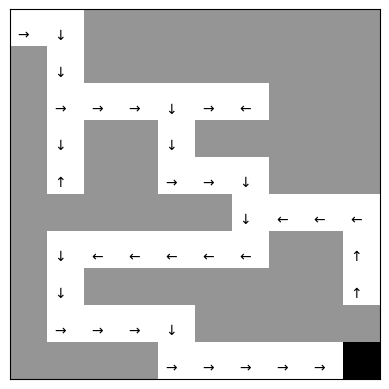

In [676]:
plot_policy(model, default_maze)

In [674]:
for i in range(5): train(model)
# train(model)

epoch:    49 loss: 0.03221626
epoch:    99 loss: 0.01865194
epoch:   149 loss: 0.01847788
epoch:   199 loss: 0.01841548
epoch:   249 loss: 0.01835011
epoch:   299 loss: 0.01828020
epoch:   349 loss: 0.01820957
epoch:   399 loss: 0.01812495
epoch:   449 loss: 0.01803746
epoch:   499 loss: 0.01793839
epoch:   549 loss: 0.01787694
epoch:   599 loss: 0.01749574
epoch:   649 loss: 0.01694041
epoch:   699 loss: 0.01658047
epoch:   749 loss: 0.01622530
epoch:   799 loss: 0.01580914
epoch:   849 loss: 0.01522315
epoch:   899 loss: 0.01492233
epoch:   949 loss: 0.01359002
epoch:   999 loss: 0.01276666
epoch:    49 loss: 0.03089534
epoch:    99 loss: 0.01238518
epoch:   149 loss: 0.01201680
epoch:   199 loss: 0.01175677
epoch:   249 loss: 0.01148202
epoch:   299 loss: 0.01119022
epoch:   349 loss: 0.01087812
epoch:   399 loss: 0.01054123
epoch:   449 loss: 0.01020436
epoch:   499 loss: 0.00986554
epoch:   549 loss: 0.00951744
epoch:   599 loss: 0.00916257
epoch:   649 loss: 0.00880700
epoch:   6

In [206]:
# backup to disk
# --------------
# torch.save(model.state_dict(), 'maze.pt')

# load from disk
# --------------
# m = NeuralNetwork()
# m.load_state_dict(torch.load('maze.pt'))